# HW 1 – FP Mining, MovieLens

Name: Jimmy Pronchick  

Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2023
Due: Friday, March 3
Instructor: Brian King

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import scipy.stats as stats
import plotly.express as px
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from langdetect import detect

In [2]:
links=pd.read_csv('../data/links.csv')
movies=pd.read_csv('../data/movies.csv')
ratings=pd.read_csv('../data/ratings.csv')
tags=pd.read_csv('../data/tags.csv')
ratings.movieId=pd.Categorical(ratings.movieId)

In [3]:
movies = movies.set_index(movies.movieId)

## Phase I

### Timestamp EDA

Text(0.5, 1.0, 'Distribution of Use Period and Average Rating Given per user')

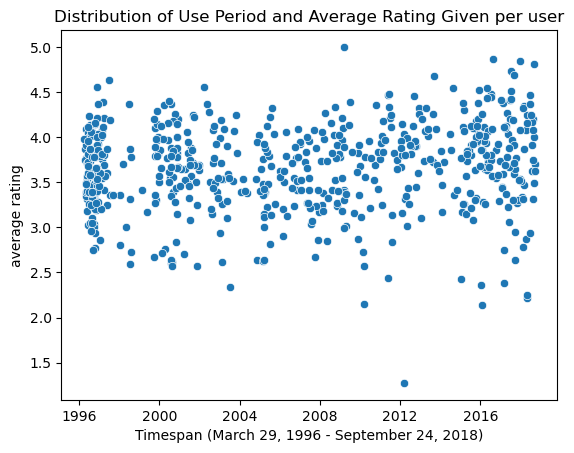

In [41]:
ratings['time_conv']=ratings.timestamp.apply(lambda x: pd.Timestamp(x,unit='s'))

rating_time=ratings.groupby(by='userId',group_keys=True).time_conv.mean()

sns.scatterplot(x=rating_time,y=ratings.groupby(by='userId',group_keys=True).rating.mean())
plt.ylabel('average rating')
plt.xlabel('Timespan (March 29, 1996 - September 24, 2018)')
plt.title('Distribution of Use Period and Average Rating Given per user')

In the plot above, 'Use Period' refers to the average day, time, year a user left a rating, which gives a general sense of when they were using the site.

Text(0.5, 1.0, 'Yearly Average and Total Ratings')

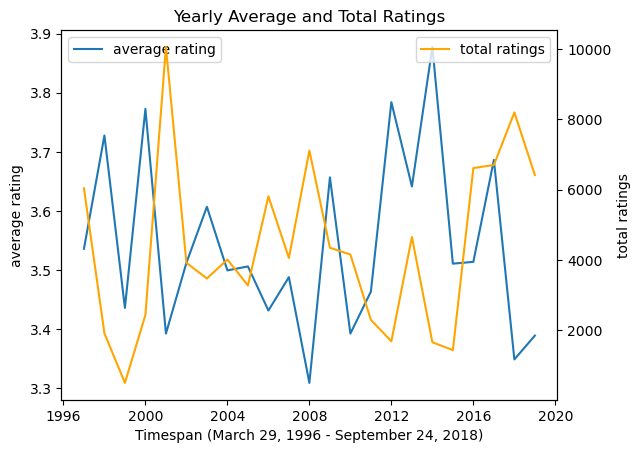

In [42]:
sns.lineplot(ratings.resample('Y',on='time_conv').rating.mean(),label='average rating')
plt.xlabel('Timespan (March 29, 1996 - September 24, 2018)')
plt.ylabel('average rating')

ax2 = plt.twinx()
sns.lineplot(ratings.resample('Y',on='time_conv').rating.count(), color="orange", ax=ax2,label='total ratings')
plt.ylabel('total ratings')
plt.legend()
plt.title('Yearly Average and Total Ratings')

The plot above shows average rating across all movies for each year, as well as the total number of ratings for each year.

### Ratings Statistics

Text(0, 0.5, 'Total Ratings')

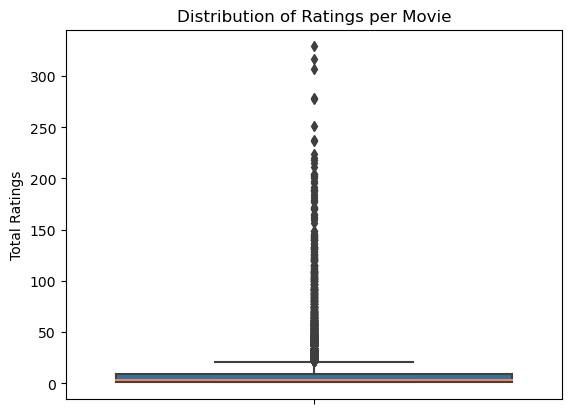

In [ ]:
sns.boxplot(y=ratings.groupby(by='movieId').userId.count(),medianprops={"color": "coral"})
plt.title("Distribution of Ratings per Movie")
plt.ylabel("Total Ratings")

In [5]:
total_ratings=ratings.groupby(by='movieId').userId.count()
movies['total_ratings']=total_ratings
movies.sort_values(by='total_ratings',ascending=False).head(10).style.set_caption("Top 10 Most Rated Movies")

,movieId,title,genres,total_ratings
movieId,,,,
356,356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.000000
318,318,"Shawshank Redemption, The (1994)",Crime|Drama,317.000000
296,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.000000
593,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.000000
2571,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.000000
260,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.000000
480,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.000000
110,110,Braveheart (1995),Action|Drama|War,237.000000
589,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.000000


In [6]:
movies.sort_values(by='total_ratings').head(10).head(10).style.set_caption("Movies with the Least Ratings")

,movieId,title,genres,total_ratings
movieId,,,,
193609,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,1.000000
4032,4032,"Everlasting Piece, An (2000)",Comedy,1.000000
57526,57526,Untraceable (2008),Crime|Thriller,1.000000
57522,57522,First Sunday (2008),Comedy|Crime,1.000000
57502,57502,Cat Soup (Nekojiru-so) (2001),Adventure|Animation|Drama|Horror,1.000000
57499,57499,Heaven and Earth (Ten to Chi to) (1990),Action|Adventure|Drama|War,1.000000
57421,57421,Hatchet (2006),Comedy|Horror,1.000000
57326,57326,In the Name of the King: A Dungeon Siege Tale (2008),Action|Adventure|Fantasy,1.000000
57147,57147,Cassandra's Dream (2007),Crime|Drama|Thriller,1.000000


In [7]:
movies['avg_rating']=ratings.groupby(by='movieId').rating.mean()
movies.sort_values(by='avg_rating',ascending=False).head(10).style.set_caption("Movies with the Highest Avg Ratings")

,movieId,title,genres,total_ratings,avg_rating
movieId,,,,,
88448,88448,Paper Birds (Pájaros de papel) (2010),Comedy|Drama,1.000000,5.000000
100556,100556,"Act of Killing, The (2012)",Documentary,1.000000,5.000000
143031,143031,Jump In! (2007),Comedy|Drama|Romance,1.000000,5.000000
143511,143511,Human (2015),Documentary,1.000000,5.000000
143559,143559,L.A. Slasher (2015),Comedy|Crime|Fantasy,1.000000,5.000000
6201,6201,Lady Jane (1986),Drama|Romance,1.000000,5.000000
102217,102217,Bill Hicks: Revelations (1993),Comedy,1.000000,5.000000
102084,102084,Justice League: Doom (2012),Action|Animation|Fantasy,1.000000,5.000000
6192,6192,Open Hearts (Elsker dig for evigt) (2002),Romance,1.000000,5.000000


Unfortunately, taking the mean rating of every film doesn't show us the films that are loved by the consensus, since many films have a single five star rating. For now the quantity of ratings is a decent metric to turn to.

In [8]:
movies.sort_values(by='avg_rating').head(10).style.set_caption("Movies with the Lowest Avg Ratings")

,movieId,title,genres,total_ratings,avg_rating
movieId,,,,,
26696,26696,Lionheart (1990),Action,1.000000,0.500000
3604,3604,Gypsy (1962),Musical,1.000000,0.500000
7312,7312,"Follow Me, Boys! (1966)",Comedy|Drama,1.000000,0.500000
145724,145724,Idaho Transfer (1973),Sci-Fi,1.000000,0.500000
76030,76030,Case 39 (2009),Horror|Thriller,1.000000,0.500000
145951,145951,Bloodsport: The Dark Kumite (1999),Action|Thriller,1.000000,0.500000
85334,85334,Hard Ticket to Hawaii (1987),Action|Comedy,1.000000,0.500000
129250,129250,Superfast! (2015),(no genres listed),1.000000,0.500000
102025,102025,Yongary: Monster from the Deep (1967),Children|Horror|Sci-Fi,1.000000,0.500000


Text(0, 0.5, 'Total Ratings')

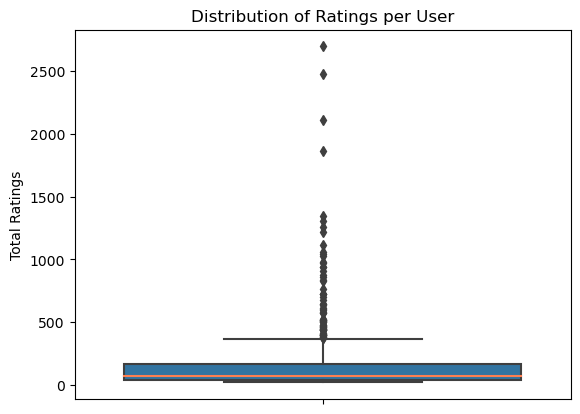

In [9]:
sns.boxplot(y=ratings.groupby(by='userId').movieId.count(),medianprops={"color": "coral"})
plt.title("Distribution of Ratings per User")
plt.ylabel("Total Ratings")

## Phase II

In [10]:
te = TransactionEncoder()
watch_lists = ratings.groupby(by='userId').movieId.unique()

te_ary = te.fit(watch_lists).transform(watch_lists)
df = pd.DataFrame(te_ary, columns=movies.title.loc[te.columns_])

In [11]:
df_freq=apriori(df, min_support=.15,use_colnames=True)
df_freq.sort_values(by='support',ascending=False).head(20)

,support,itemsets
32,0.539344,(Forrest Gump (1994))
27,0.519672,"(Shawshank Redemption, The (1994))"
25,0.503279,(Pulp Fiction (1994))
53,0.457377,"(Silence of the Lambs, The (1991))"
108,0.455738,"(Matrix, The (1999))"
21,0.411475,(Star Wars: Episode IV - A New Hope (1977))
41,0.390164,(Jurassic Park (1993))
10,0.388525,(Braveheart (1995))
509,0.378689,"(Forrest Gump (1994), Shawshank Redemption, Th..."
444,0.377049,"(Forrest Gump (1994), Pulp Fiction (1994))"


In [12]:
def formatter(df):
    formatted = pd.DataFrame({'If you enjoyed:':df.antecedents,'You might like these films:':df.consequents,
                          "Confidence Level:":df.confidence})
    
    formatted.iloc[:,2] = formatted.iloc[:,2].apply(lambda x:'{:.2f}'.format(x))
    formatted.iloc[:,0]=formatted.iloc[:,0].apply(lambda x: str(x).strip("frozenset{({})}"))
    formatted.iloc[:,1]=formatted.iloc[:,1].apply(lambda x: str(x).strip("frozenset{({})}"))

    formatted=formatted.style.background_gradient(gmap=formatted['Confidence Level:'], cmap='YlGn')
    return formatted

In [13]:
pd.set_option('display.max_colwidth', None)
rules=association_rules(df_freq, metric="support", min_threshold=0.01)
rules=rules[(rules.antecedents.apply(lambda x:len(x)==1))&(rules.consequents.apply(lambda x:len(x)>1))]
r_interesting=rules[(rules.confidence>.75)&(rules.iloc[:,2]<.3)].sort_values(by='confidence',ascending=False)
formatter(r_interesting)

,If you enjoyed:,You might like these films:,Confidence Level:
9369,'Kill Bill: Vol. 2 (2004)',"'Fight Club (1999)', 'Kill Bill: Vol. 1 (2003)'",0.84
4550,'Indiana Jones and the Last Crusade (1989)',"'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)'",0.82
8313,"'Terminator, The (1984)'","'Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)'",0.80
4532,"'Terminator, The (1984)'","'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)'",0.79
4645,'Indiana Jones and the Last Crusade (1989)',"'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Star Wars: Episode IV - A New Hope (1977)'",0.79
4712,'Indiana Jones and the Last Crusade (1989)',"'Star Wars: Episode VI - Return of the Jedi (1983)', 'Star Wars: Episode IV - A New Hope (1977)'",0.79
8679,'Indiana Jones and the Last Crusade (1989)',"'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)'",0.79
6884,'Mrs. Doubtfire (1993)',"'Forrest Gump (1994)', 'Jurassic Park (1993)'",0.78
4574,'Star Wars: Episode I - The Phantom Menace (1999)',"'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)'",0.78
8642,'Indiana Jones and the Last Crusade (1989)',"'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'",0.77


This set of rules takes a single film a user watched and recommends them multiple new films that are similar in genre, period, and subject matter. In order to achieve this, I looked for rules that contain single antecedents with multiple consequents, while filtering out high antecedent support. This was to keep every most popular film from dominating the list. The remaining rules with high confidence levels show 

## Phase III

In [14]:
romance_movies = movies[movies.genres.apply(lambda x:"Romance"in x)]
AHH = movies[movies.genres.apply(lambda x:"Horror"in x)]
AHH_haha = movies[movies.genres.apply(lambda x:("Horror"in x)&("Comedy"in x))]

In [15]:
romance_ratings=ratings[ratings.movieId.apply(lambda x: x in romance_movies.index)]
horror_ratings=ratings[ratings.movieId.apply(lambda x: x in AHH.index)]
horr_comedy=ratings[ratings.movieId.apply(lambda x: x in AHH_haha.index)]

watch_lists_romance = romance_ratings.groupby(by='userId').movieId.unique()
watch_lists_horror = horror_ratings.groupby(by='userId').movieId.unique()
watch_lists_horr_comedy = horr_comedy.groupby(by='userId').movieId.unique()

In [16]:
te_ary = te.fit(watch_lists_romance).transform(watch_lists_romance)
df_romance = pd.DataFrame(te_ary, columns=movies.title.loc[te.columns_])

In [17]:
te_ary = te.fit(watch_lists_horror).transform(watch_lists_horror)
df_horror = pd.DataFrame(te_ary, columns=movies.title.loc[te.columns_])

In [18]:
te_ary = te.fit(watch_lists_horr_comedy).transform(watch_lists_horr_comedy)
df_horr_comedy = pd.DataFrame(te_ary, columns=movies.title.loc[te.columns_])

In [19]:
def generate_rules(df,minsup):
    df_freq=apriori(df,min_support=minsup,use_colnames=True)
    rules=association_rules(df_freq, metric="support", min_threshold=0.01)
    return rules.sort_values(by='support',ascending=False).head(3000)

In [20]:
romance_rules=generate_rules(df_romance,.1)
romance_rules=romance_rules[(romance_rules.consequents.apply(lambda x:len(x)>1))]
romance_rules=romance_rules[(romance_rules.iloc[:,3]<.2)&(romance_rules.confidence>.6)].sort_values(by='confidence',ascending=False)
formatter(romance_rules)

,If you enjoyed:,You might like these films:,Confidence Level:
662,"'Sleepless in Seattle (1993)', 'Pretty Woman (1990)'","'Forrest Gump (1994)', 'Ghost (1990)'",0.78
663,"'Ghost (1990)', 'Pretty Woman (1990)'","'Forrest Gump (1994)', 'Sleepless in Seattle (1993)'",0.76
621,"'Speed (1994)', 'Pretty Woman (1990)'","'Forrest Gump (1994)', 'Sleepless in Seattle (1993)'",0.72
648,"'True Lies (1994)', 'Pretty Woman (1990)'","'Forrest Gump (1994)', 'Ghost (1990)'",0.71
616,"'Forrest Gump (1994)', 'Sleepless in Seattle (1993)'","'Speed (1994)', 'Pretty Woman (1990)'",0.69
634,"'Speed (1994)', 'Pretty Woman (1990)'","'Forrest Gump (1994)', 'Ghost (1990)'",0.69
545,'Sleepless in Seattle (1993)',"'Speed (1994)', 'Pretty Woman (1990)'",0.65
658,"'Forrest Gump (1994)', 'Sleepless in Seattle (1993)'","'Ghost (1990)', 'Pretty Woman (1990)'",0.65
342,'Sleepless in Seattle (1993)',"'Forrest Gump (1994)', 'Ghost (1990)'",0.64
623,'Sleepless in Seattle (1993)',"'Forrest Gump (1994)', 'Speed (1994)', 'Pretty Woman (1990)'",0.63


In [21]:
horror_rules=generate_rules(df_horror,.1)
horror_rules=horror_rules[(horror_rules.consequents.apply(lambda x:len(x)>1))]
horror_rules=horror_rules[(horror_rules.iloc[:,3]<.2)&(horror_rules.confidence>.5)].sort_values(by='confidence',ascending=False)
formatter(horror_rules)

,If you enjoyed:,You might like these films:,Confidence Level:
93,"'Aliens (1986)', 'Sixth Sense, The (1999)'","'Alien (1979)', 'Silence of the Lambs, The (1991)'",0.73
91,"'Silence of the Lambs, The (1991)', 'Aliens (1986)'","'Alien (1979)', 'Sixth Sense, The (1999)'",0.68
90,"'Alien (1979)', 'Sixth Sense, The (1999)'","'Silence of the Lambs, The (1991)', 'Aliens (1986)'",0.63
47,'Aliens (1986)',"'Alien (1979)', 'Silence of the Lambs, The (1991)'",0.57
88,"'Alien (1979)', 'Silence of the Lambs, The (1991)'","'Aliens (1986)', 'Sixth Sense, The (1999)'",0.56
59,"'Shining, The (1980)'","'Alien (1979)', 'Silence of the Lambs, The (1991)'",0.54
76,'Aliens (1986)',"'Alien (1979)', 'Sixth Sense, The (1999)'",0.53


In [22]:
hahahorror_rules=generate_rules(df_horr_comedy,.05)
hahahorror_rules=hahahorror_rules[(hahahorror_rules.iloc[:,3]<.2)&(hahahorror_rules.confidence>.6)].sort_values(by='confidence',ascending=False)
formatter(hahahorror_rules)

,If you enjoyed:,You might like these films:,Confidence Level:
104,'Scary Movie 3 (2003)','Scary Movie (2000)',0.80
119,"'Mummy, The (1999)', 'Army of Darkness (1993)'",'Gremlins (1984)',0.74
16,'Evil Dead II (Dead by Dawn) (1987)','Army of Darkness (1993)',0.74
149,"'Shaun of the Dead (2004)', 'Scream (1996)'",'Scary Movie (2000)',0.67
161,"'Mummy, The (1999)', 'Arachnophobia (1990)'",'Gremlins (1984)',0.65
160,"'Mummy, The (1999)', 'Gremlins (1984)'",'Arachnophobia (1990)',0.65
118,"'Mummy, The (1999)', 'Gremlins (1984)'",'Army of Darkness (1993)',0.65
215,"'Rocky Horror Picture Show, The (1975)', 'Shaun of the Dead (2004)'",'Scary Movie (2000)',0.62
208,"'Rocky Horror Picture Show, The (1975)', 'Shaun of the Dead (2004)'",'Arachnophobia (1990)',0.62
73,'Buffy the Vampire Slayer (1992)','Gremlins (1984)',0.62


### Discussion

Each of the rule sets above priortize high confidence rules generated by antecedents with lower support, in order to suppress the skewing caused by the most commonly watched films and let the strong, genre or content based associations shine through.

## Phase IV

In [23]:
genre_lists=ratings.groupby(by='userId').movieId.unique().map(lambda x: movies.genres.loc[x].to_numpy())

In [24]:
te_ary = te.fit(genre_lists).transform(genre_lists)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [25]:
genre_rules=generate_rules(df,.4)
genre_rules=genre_rules[(genre_rules.antecedents.apply(lambda x:
                                                       len(str(x).split('|'))==1))]

In [26]:
genre_rules=genre_rules[genre_rules.apply(lambda x: str(x.antecedents).strip('\'frozenset({})\'') 
                                          not in str(x.consequents),axis=1)]
genre_rules=genre_rules[(genre_rules.antecedents.apply(lambda x:len(x)==1))]
genre_rules=genre_rules[genre_rules.confidence>.7].sort_values(by='confidence',ascending=False)
formatter(genre_rules)

,If you enjoyed:,You might like these films:,Confidence Level:
246,'Drama','Comedy',0.90
247,'Comedy','Drama',0.89
338,'Drama','Comedy|Romance',0.81
251,'Comedy','Drama|Romance',0.81
239,'Comedy','Crime|Drama',0.79
2803,'Drama',"'Comedy|Romance', 'Comedy'",0.77
2889,'Comedy',"'Drama', 'Drama|Romance'",0.76
17,'Comedy','Action|Adventure|Sci-Fi',0.75
30,'Drama','Action|Adventure|Sci-Fi',0.74
2841,'Comedy',"'Drama', 'Crime|Drama'",0.73


This list takes 'pure' genres and recommends a mix of genres that a user might like based on their interest in that pure genre. The rules are filtered so that the antecedent genre cannot appear in the consequents, so there won't be any "If you like Comedy, you might like Comedy|Romance". Instead the recommendations are mix of distinct genres that might approximate the antecedent.

## Phase V

### Movies with Alliteration in the Title

In [27]:
def alliteration(title):
    for i in range(len(title)-1):
        if (title[i][0]!=title[i+1][0]):
            return False
    return True

In [28]:
movies['title_words']=movies.title.apply(lambda x:x.split()[:-1])

In [29]:
multiword_titles=movies[movies.title_words.apply(lambda x: len(x)>1)]
alliteration_movies=multiword_titles[multiword_titles.title_words.apply(lambda x:alliteration(x))]

In [32]:
allit_ratings=ratings[ratings.movieId.apply(lambda x: x in alliteration_movies.index)]
allit_lists=allit_ratings.groupby(by='userId').movieId.unique()

te_ary = te.fit(allit_lists).transform(allit_lists)
df = pd.DataFrame(te_ary, columns=movies.title.loc[te.columns_])
df_allit_freq=generate_rules(df,.02)
df_allit_freq=df_allit_freq[df_allit_freq.confidence>.9]
df_allit_freq=df_allit_freq[df_allit_freq.lift>4]
formatter(df_allit_freq.sort_values(by='confidence',ascending=False))

,If you enjoyed:,You might like these films:,Confidence Level:
6048,"'Mad Max (1979)', 'Fantastic Four (2005)'","'Batman Begins (2005)', 'Terminator, The (1984)'",1.00
6900,"'Wild Wild West (1999)', 'Batman Begins (2005)', ""Wayne's World (1992)""",'Liar Liar (1997)',0.94
11315,"'Donnie Darko (2001)', 'Liar Liar (1997)', 'King Kong (2005)'","'Batman Begins (2005)', 'Terminator, The (1984)'",0.94
13435,"'Donnie Darko (2001)', 'Fantastic Four (2005)', 'Batman Begins (2005)', 'Terminator, The (1984)'",'King Kong (2005)',0.93
6423,"'Donnie Darko (2001)', 'Fantastic Four (2005)', 'Terminator, The (1984)'",'King Kong (2005)',0.93
13885,"'Wild Wild West (1999)', 'Donnie Darko (2001)', 'Batman Begins (2005)', ""Wayne's World (1992)""",'Liar Liar (1997)',0.93
13446,"'Donnie Darko (2001)', 'Fantastic Four (2005)', 'Terminator, The (1984)'","'Batman Begins (2005)', 'King Kong (2005)'",0.93
4493,"'King Kong (2005)', ""Wayne's World (1992)"", 'Terminator, The (1984)'",'Liar Liar (1997)',0.93
7262,"'Donnie Darko (2001)', 'Terminal, The (2004)', 'Liar Liar (1997)'","""Wayne's World (1992)""",0.93
12668,"'King Kong (2005)', ""Wayne's World (1992)"", 'Terminator, The (1984)'","'Donnie Darko (2001)', 'Batman Begins (2005)'",0.93


This grouping captures some campy comedy and action movies (and Donnie Darko) that follow a particular naming convention. Also shown below are all titles that have three or more alliterate words.

In [31]:
alliteration_movies[alliteration_movies.title_words.apply(lambda x: len(x)>2)]

,movieId,title,genres,total_ratings,avg_rating,title_words
movieId,,,,,,
492,492,Manhattan Murder Mystery (1993),Comedy|Mystery,14.0,3.750000,"[Manhattan, Murder, Mystery]"
2701,2701,Wild Wild West (1999),Action|Comedy|Sci-Fi|Western,53.0,2.207547,"[Wild, Wild, West]"
3066,3066,Tora! Tora! Tora! (1970),Action|Drama|War,7.0,3.928571,"[Tora!, Tora!, Tora!]"
3719,3719,Love's Labour's Lost (2000),Comedy|Romance,2.0,3.000000,"[Love's, Labour's, Lost]"
4018,4018,What Women Want (2000),Comedy|Romance,54.0,3.138889,"[What, Women, Want]"
4394,4394,Beach Blanket Bingo (1965),Comedy|Musical,1.0,1.500000,"[Beach, Blanket, Bingo]"
6030,6030,Girls! Girls! Girls! (1962),Comedy|Musical,1.0,2.000000,"[Girls!, Girls!, Girls!]"
26810,26810,Bad Boy Bubby (1993),Drama,3.0,4.833333,"[Bad, Boy, Bubby]"
90374,90374,Martha Marcy May Marlene (2011),Drama|Thriller,2.0,3.750000,"[Martha, Marcy, May, Marlene]"


### Period + Genre

In [33]:
#preprocessing, grabbing decades of all films that offer the information
years=movies.title.apply(lambda x: (x.split()[-1].strip("()")))
years=years.where((years.apply(lambda x: str.isnumeric(x)))&(years.apply(lambda x: len(x)==4)))
movies['decade']=years.apply(lambda x: (int(x)//10 * 10) if type(x)==str else 0)
movies['dec_genre']=movies.apply(lambda x:str(x.loc['decade'])+"s "+x.genres,axis=1)

In [34]:
decade_lists=ratings.groupby(by='userId').movieId.unique().map(lambda x: movies.dec_genre.loc[x].to_numpy())

In [35]:
te_ary = te.fit(decade_lists).transform(decade_lists)
df = pd.DataFrame(te_ary, columns=te.columns_)
df_dec_freq=generate_rules(df,.2)

In [36]:
df_dec_freq=df_dec_freq[df_dec_freq.apply(lambda x: 
                              str(x.antecedents).split('s')[1] not in 
                              str(x.consequents).split('s')[1],axis=1)]

df_dec_freq=df_dec_freq[df_dec_freq.antecedents.apply(lambda x:len(str(x).split('|'))==1)]
df_dec_freq=df_dec_freq[df_dec_freq.confidence>.7]
formatter(df_dec_freq.sort_values(by='confidence',ascending=False))

,If you enjoyed:,You might like these films:,Confidence Level:
503,'1980s Comedy','1990s Comedy',0.84
525,'1980s Comedy','1990s Drama|Romance',0.83
591,'1980s Drama','1990s Drama|Romance',0.83
2167,'2000s Comedy','1990s Drama|Romance',0.81
2178,'2000s Drama','1990s Drama|Romance',0.79
2017,'2000s Comedy','1990s Crime|Drama',0.79
1629,'2000s Comedy','1990s Comedy',0.79
2028,'2000s Drama','1990s Crime|Drama',0.77
583,'1980s Drama','1990s Crime|Drama',0.77
1640,'2000s Drama','1990s Comedy',0.74


This grouping combines the decade and genre of each film, and the rules above are filtered so that the recommendation for an antecedent cannot come from the same decade. 

### Grouping Films by Language

In [43]:
# movies['lang']=movies.title.apply(lambda x: detect(x))

The commented out code snippet above is an attempt to group the film dataset by language, by using the python library [langdetect](https://pypi.org/project/langdetect/) to detect the language of the title. I threw this out because the detection was unreliable; titles of just one or two words did not yield consistenly correct classifications, and titles with too many numbers or odd punctatuation caused errors. Also, it is plausible for the title of a film to be unrelated or misleading in regard to the original language the film is in. 

This grouping may be possible using the 'links' dataset, which links the films to other databases, such as IMDB, that may have more data readily available, such as the language of each film.